In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import osmnx as ox
from us import states

In [2]:
lines_gdf=gpd.read_file("../data/transmission_lines/Electric__Power_Transmission_Lines/Electric__Power_Transmission_Lines.shp",
                        bbox=(-88.5,41,87.5,42.5))

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [3]:
illinois_url = states.IL.shapefile_urls()['county']
il_gdf = gpd.read_file(illinois_url,
                       bbox=(-88.5,41,87.5,42.5))

In [4]:
service_gdf = gpd.read_file("../../spatial-data/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp",
                            bbox=(-88.5,41,87.5,42.5))

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [5]:
il_gdf.to_crs(epsg=4326, inplace=True)

# Transmission

In [6]:
il_lines = gpd.sjoin(lines_gdf, il_gdf, how='inner', predicate='intersects')

## Service

In [7]:
il_service = service_gdf[service_gdf['STATE']=='IL']

In [8]:
il_service.replace(dict(zip(il_service['CNTRL_AREA'].unique(), ['MISO-Z4','ComEd','EEI'])), inplace=True)

C:\Users\sdotson\AppData\Local\Temp\ipykernel_1580\2735122013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il_service.replace(dict(zip(il_service['CNTRL_AREA'].unique(), ['MISO-Z4','ComEd','EEI'])), inplace=True)


In [9]:
il_lines.VOLTAGE.value_counts()

VOLTAGE
 138.0       596
 345.0       251
-999999.0     63
 765.0         5
Name: count, dtype: int64

In [10]:
il_lines.replace(-999999, np.nan, inplace=True)

<Axes: >

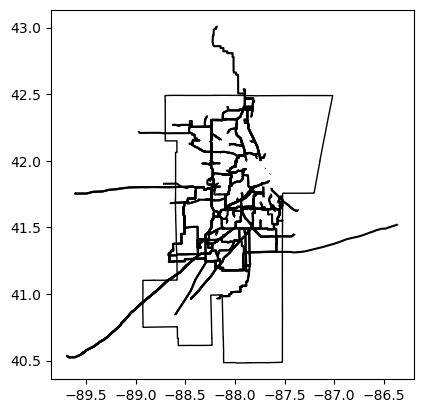

In [11]:
fig, ax = plt.subplots()
il_gdf.dissolve('STATEFP10').plot(ax=ax,facecolor='w',edgecolor='k')
# il_service.dissolve("CNTRL_AREA").reset_index().plot(ax=ax, 
#                 column='CNTRL_AREA',
#                 categorical=True,
#                 cmap='prism',
#                 legend=True,
#                 legend_kwds=dict(loc=(-0.1, -0.1), ncols=3),
#                 alpha=1,
#                 edgecolor='k')
# il_lines.plot(ax=ax, edgecolor='r')
il_lines.plot(ax=ax,
              color='k'
            #    column='VOLTAGE', 
            #    categorical=False, 
            #    cmap='cividis',
            #    legend=True,
            #    legend_kwds=dict(label='Voltage [kV]')
            )
# ax.set_axis_off()

In [12]:
il_lines[['ID','TYPE','VOLTAGE','SUB_1','SUB_2','geometry']].duplicated().sum()

149

In [13]:
il_lines_simple = il_lines[['ID','TYPE','VOLTAGE','SUB_1','SUB_2','geometry']]

In [42]:
n_lines = il_lines_simple.ID.value_counts()

In [38]:
n_lines.reset_index().sort_values(by='ID')['count']

627    1
604    1
605    1
606    1
603    1
      ..
250    1
254    1
218    1
216    1
102    2
Name: count, Length: 766, dtype: int64

In [31]:
il_lines_unique = il_lines_simple[~il_lines_simple.duplicated()]

In [41]:
il_lines_unique = il_lines_unique.sort_values(by='ID').assign(n_lines=n_lines.reset_index().sort_values(by='ID')['count'].values)

In [46]:
from unyt import meter, mile

In [48]:
(2*meter).to(mile).to_value()

0.001242742408066988

In [50]:
line_lengths = il_lines_unique.to_crs(epsg=5070).length.apply(lambda d: (d*meter).to(mile).to_value())

In [54]:
il_lines_unique = il_lines_unique.assign(length = line_lengths.values)

In [55]:
il_lines_unique

,ID,TYPE,VOLTAGE,SUB_1,SUB_2,geometry,n_lines,length
1616,100062,AC; OVERHEAD,138.0,UNKNOWN122308,PROSPECT HEIGHTS,"LINESTRING (-87.91987 42.11519, -87.92066 42.1...",1,7.788602
1813,100228,AC; OVERHEAD,138.0,UNKNOWN124430,TAP138216,"LINESTRING (-88.13106 41.56360, -88.13105 41.5...",1,5.057592
1815,100252,AC; OVERHEAD,138.0,UNKNOWN122309,PLEASANT HILL,"LINESTRING (-88.04330 41.85997, -88.04315 41.8...",1,8.086757
1817,100296,AC; OVERHEAD,138.0,UNKNOWN121940,UNKNOWN124710,"LINESTRING (-87.81741 42.38350, -87.81784 42.3...",1,12.238316
1811,100311,AC; OVERHEAD,138.0,UNKNOWN121938,TAP136957,"LINESTRING (-87.87541 42.35345, -87.87595 42.3...",1,0.049272
...,...,...,...,...,...,...,...,...
4581,175202,OVERHEAD,NaN,UNKNOWN125313,UNKNOWN172150,"LINESTRING (-87.87729 41.09211, -87.87650 41.0...",1,0.098545
4582,175203,OVERHEAD,NaN,UNKNOWN125313,UNKNOWN172150,"LINESTRING (-87.87729 41.09211, -87.87694 41.0...",1,0.104914
5205,179351,NOT AVAILABLE,NaN,UNKNOWN177307,TAP176265,"LINESTRING (-88.18761 41.41235, -88.18735 41.4...",1,0.438276
5206,179423,NOT AVAILABLE,NaN,TAP176265,TAP176657,"LINESTRING (-88.18727 41.40607, -88.18382 41.4...",1,1.812172


In [89]:
sub_1_coords = il_lines.geometry.apply(lambda x: x.boundary.geoms[0])
sub_2_coords = il_lines.geometry.apply(lambda x: x.boundary.geoms[1])

In [98]:
sub_1_coords.values[0].x

-88.2350718

In [90]:
import pypsa

In [94]:
for index, row in il_lines.iterrows():
    voltage = row['VOLTAGE']
    sub_1_coords = 
    print(row['SUB_1'])

UNKNOWN121953
TAP137953
UNKNOWN122316
UNKNOWN121903
UNKNOWN122013
LOCKPORT
UNKNOWN122289
UNKNOWN121936
UNKNOWN121992
ROCKY ROAD POWER LLC
ROCKY ROAD POWER LLC
UNKNOWN121983
UNKNOWN124693
TOLLWAY
TAP138212
PROSPECT HEIGHTS
UNKNOWN121984
TAP138241
UNKNOWN121898
UNKNOWN122289
UNKNOWN122311
UNKNOWN122311
TAP137894
TAP138252
TAP137900
ELWOOD
ELWOOD
UNKNOWN122288
ZION
TAP138146
TAP138163
UNKNOWN121938
UNKNOWN122290
AURORA
UNKNOWN121893
UNKNOWN121893
TAP137897
TAP137897
UNKNOWN124428
UNKNOWN124428
UNKNOWN124083
UNKNOWN121936
UNKNOWN122289
TAP138179
TAP138179
JOLIET
DRESDEN GENERATING STATION
TAP138156
UNKNOWN122288
UNKNOWN121955
UNKNOWN122299
TAP137890
TAP137924
LOMBARD
UNKNOWN124710
UNKNOWN123355
UNKNOWN124839
TAP138175
TOLLWAY
TOLLWAY
UNKNOWN133790
UNKNOWN133790
TAP138148
TAP136957
UNKNOWN122313
LA SALLE
LA SALLE
WILL COUNTY
UNKNOWN121987
TAP138221
TAP138171
TAP138239
UNKNOWN121993
UNKNOWN121899
UNKNOWN125312
BURNHAM
UNKNOWN121906
UNKNOWN124700
UNKNOWN121893
UNKNOWN121893
LOCKPORT
LOCKPORT
